### Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from yellowbrick.regressor import PredictionError
from yellowbrick.features.importances import FeatureImportances
from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.classifier import ClassificationReport
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import StratifiedKFold
from sklearn_porter import Porter

### Load data

In [5]:
dataset = pd.read_csv('../results/Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz/Intersect_masterset.csv')
dataset.columns = dataset.columns.str.strip()
dataset.head()

,range,n1,average1,std1,n2,average2,std2,skewed_1,skewed_2,non_skewed,fastest_algo
0,65518,9862,16767.2,21066.0,9862,16767.2,21066.0,1744,376,9057,skewed_2
1,65518,9862,16767.2,21066.0,10,20967.0,22080.1,433,219,151,non_skewed
2,65518,9862,16767.2,21066.0,4,21096.2,24358.7,396,76,113,skewed_2
3,65518,9862,16767.2,21066.0,48,22803.3,22462.6,467,258,15599,skewed_2
4,65518,9862,16767.2,21066.0,3131,17175.5,21213.4,908,411,1413,skewed_2


### Shape datasets

In [6]:
feature_cols = ['average1', 'n1','n2', 'average2']

In [7]:
#feature_cols = ['n1', 'n2']

In [8]:
# All rows, and the feature_cols' columns
X = dataset.loc[:, feature_cols]
#scaler = preprocessing.StandardScaler()
#X = scaler.fit_transform(X)
X.shape

(640000, 4)

In [9]:
ys = []
algos = ['skewed_1', 'skewed_2', 'non_skewed']
for algo in algos:
    y = dataset.loc[:, algo]
    ys.append(y)
y.shape

(640000,)

In [10]:
sets = []
for index, y in enumerate(ys):  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    sets.append((X_train, X_test, y_train, y_test, algos[index]))
"train: " + str(y_train.shape) + " test: " + str(y_test.shape)

'train: (512000,) test: (128000,)'

# Regression

### Train regression model

In [13]:
def regPredictionError():
    fig = plt.figure()
    fig.subplots_adjust(bottom= 1, top= 3.5, left=1, right=3)
    for index, (X_train, X_test, y_train, y_test, filename) in enumerate(sets):
        ax = fig.add_subplot(2,2,index+1)

        visualizer = PredictionError(LinearRegression(n_jobs=-1), ax=ax)

        visualizer.fit(X_train, y_train)
        visualizer.score(X_test, y_test)
        visualizer.finalize()
        ax.set_title(filename)
    plt.show()

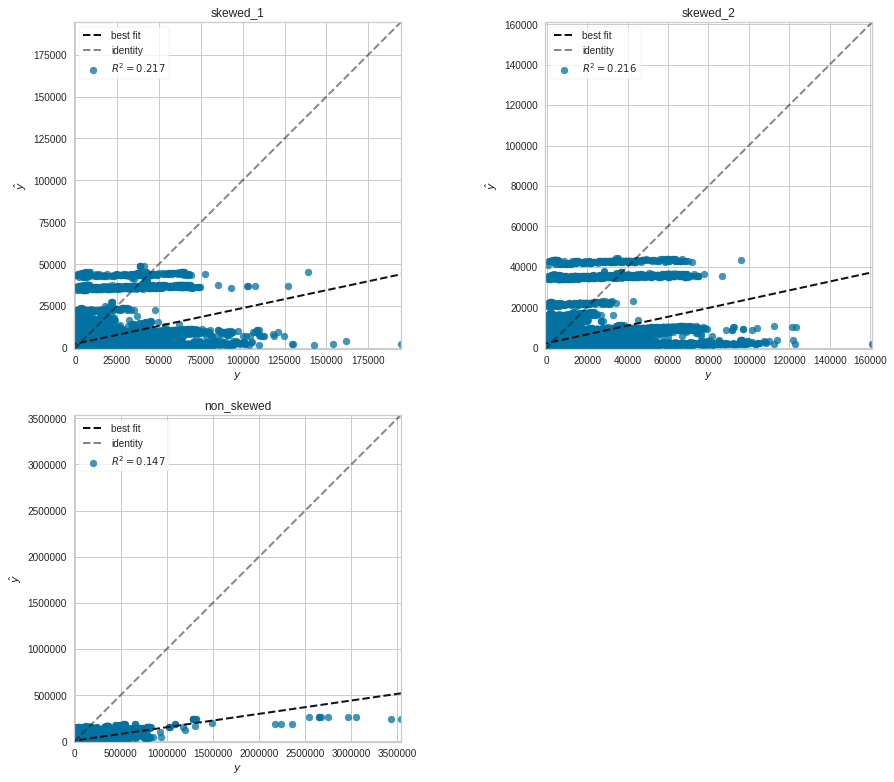

In [14]:
regPredictionError()

### Regression Feature Importances

In [20]:
def regFeatureImportances():
    fig = plt.figure()
    fig.subplots_adjust(bottom= 1, top= 3.5, left=1, right=3)
    for index, y in enumerate(ys):
        ax = fig.add_subplot(2,2,index+1)
        labels = list(map(lambda s: s.title(), feature_cols))
        viz = FeatureImportances(LinearRegression(n_jobs=-1), labels=labels, ax=ax, relative=False)
        viz.fit(X, y)
        ax.set_title(algos[index])
        ax.set_xlabel("Coefficient value")
    plt.show()

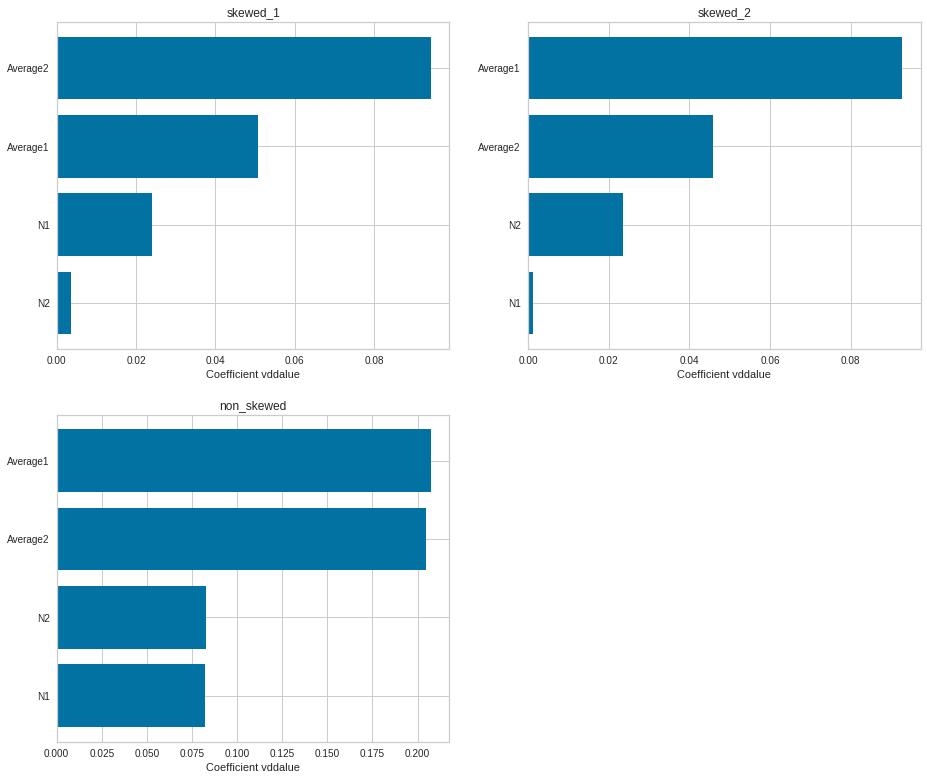

In [19]:
regFeatureImportances()

### Regression Learning Curve

In [ ]:
def regLearningCurve():
    sizes = np.linspace(0.3, 1.0, 10)

    fig = plt.figure()
    fig.subplots_adjust(bottom= 1, top= 3.5, left=1, right=3)
    for index, y in enumerate(ys):
        ax = fig.add_subplot(2,2,index+1)
        viz = LearningCurve(LinearRegression(n_jobs=-1), scoring='r2', train_sizes=sizes, n_jobs=4, ax=ax)
        viz.fit(X, y)
        viz.finalize()
        ax.set_title(algos[index])
    plt.show()

In [ ]:
regLearningCurve()

### Regression Validation Curve

In [ ]:
def regValidationCurve():
    param_range = np.arange(100, 1000, 100)
    fig = plt.figure()
    fig.subplots_adjust(bottom= 1, top= 3.5, left=1, right=3)
    for index, y in enumerate(ys):
        ax = fig.add_subplot(2,2,index+1)
        viz = ValidationCurve(
        SGDRegressor(), param_name="max_iter", param_range=param_range,
            scoring="r2", n_jobs=4, ax=ax)
        viz.fit(X, y)
        viz.finalize()
        ax.set_title(algos[index])
    plt.show()

In [ ]:
regValidationCurve()

# Classification

In [21]:
# Make images larger
import matplotlib as mpl
plt.rcParams['figure.dpi'] = 125

### Build Classification dataset

In [22]:
list(dataset)

['range',
 'n1',
 'average1',
 'std1',
 'n2',
 'average2',
 'std2',
 'skewed_1',
 'skewed_2',
 'non_skewed',
 'fastest_algo']

In [23]:
feature_cols = ['range',
 'n1',
 'average1',
 'median1',
 'std1',
 'n2',
 'average2',
 'median2',
 'std2'
]

In [24]:
X = dataset.loc[:, feature_cols]
# scaler = preprocessing.StandardScaler()
# X = scaler.fit_transform(X)
X = X.values

/home/jeremie/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [25]:
cy = []
cyTimes = []
for i in range(len(ys[0])):
    minVal = float("inf")
    minName = ""
    for j, y in enumerate(ys):
        if (minVal > y[i]):
            minVal = y[i]
            minName = algos[j]
    cy.append(minName)
    cyTimes.append(minVal)
cy = np.array(cy)
cy.shape

(640000,)

In [ ]:
def clfSplit():
    return train_test_split(X, cy, test_size=0.2, random_state=0)

### Train Classification model

In [ ]:
def clfReport():
    X_train, X_test, y_train, y_test = clfSplit()
    visualizer = ClassificationReport(RandomForestClassifier(n_estimators=5), support='percent')

    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.poof()

In [ ]:
clfReport()

### Confusion Matrix

In [ ]:
def confusionMatrix():
    X_train, X_test, y_train, y_test = clfSplit()
    cm = ConfusionMatrix(RandomForestClassifier(n_estimators=5))
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)

    cm.poof()

In [ ]:
confusionMatrix()

### Classification Feature importances

In [ ]:
def clfFeatureImportances():
    labels = list(map(lambda s: s.title(), feature_cols))
    viz = FeatureImportances(RandomForestClassifier(n_estimators=5), labels=labels, relative=True)
    viz.fit(X, cy)
    viz.poof()

In [ ]:
clfFeatureImportances()

### Classification learning curve

In [ ]:
def clfLearningCurve():
    sizes = np.linspace(0.15, 1.0, 10)

    viz = LearningCurve(
        RandomForestClassifier(n_estimators=10), train_sizes=sizes,
        scoring='f1_weighted', n_jobs=-1
    )

    viz.fit(X, cy)
    viz.poof()

In [ ]:
clfLearningCurve()

### Classification Validation Curve

In [ ]:
def clfValidationCurve():
    param_range = np.arange(1, 30, 1)

    viz = ValidationCurve(
        RandomForestClassifier(), param_name="n_estimators", param_range=param_range,
        scoring="f1_weighted", n_jobs=-1)

    viz.fit(X, cy)
    viz.poof()

In [ ]:
clfValidationCurve()

### Export Classification model to C

In [ ]:
def exportClassifierToC():
    clf = DecisionTreeClassifier(max_depth=1)
    clf.fit(X, cy)

    porter = Porter(clf, language='c')
    output = porter.export(embed_data=True)

    with open('tree.c', 'w') as f:
        f.write(output)

In [ ]:
exportClassifierToC()